# Exploratory Data Analysis

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from itertools import chain
import pydicom
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
72603,00017897_002.png,No Finding,2,17897,43,M,PA,2992,2991,0.143,0.143,NaN
52423,00013234_000.png,Effusion|Pleural_Thickening,0,13234,44,M,PA,2992,2991,0.143,0.143,NaN
34199,00008964_004.png,Effusion,4,8964,56,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
# create a subset dataset
cols = ['Finding Labels', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
all_xray_df = all_xray_df[cols]

In [4]:
## Split up "Finding Labels" column so that there is one column in the dataframe
# per disease, with a binary flag.

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
# Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1240,00006519_026.png,Atelectasis|Effusion|Infiltration,26,6519,059Y,M,AP,2500,2048,0.168,0.168
3600,00017721_001.png,No Finding,1,17721,029Y,M,PA,2992,2769,0.143,0.143
1848,00009727_037.png,Infiltration,37,9727,014Y,F,AP,2500,2048,0.168,0.168


## Demographics:

### Distribution by Patient Age:

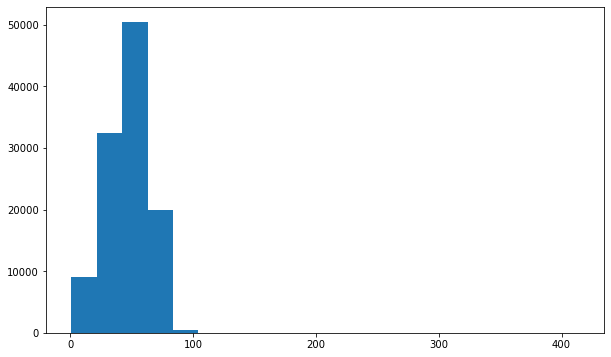

In [6]:
# histogram of patient's age
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins=20,);

Looks like there are values in age beyond 100 which means some of the values could be in days or months. It's difficult to ascertain whether age is in years, month or days from NIH data since Y, M or D label is missing.

Plotting age less than 100:

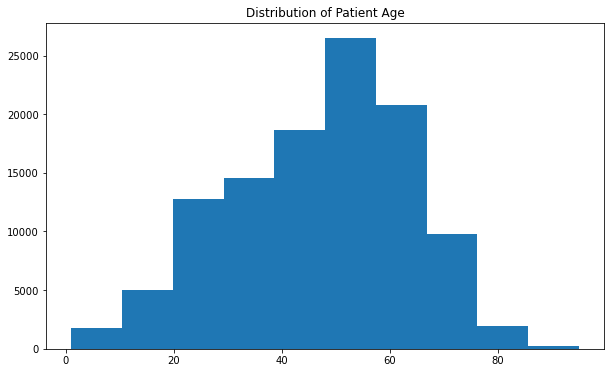

In [7]:
# histogram of patient's age less than 100
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'][all_xray_df['Patient Age']<100], bins=10,)
plt.title('Distribution of Patient Age') ;

Median age is between 50 and 60. 

**Pneumonia by Age:**

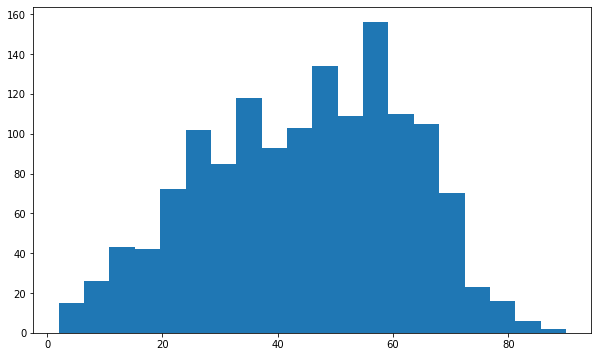

In [17]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[(all_xray_df['Pneumonia'] ==1) & (all_xray_df['Patient Age'] < 100)]['Patient Age'], bins=20);

**Pneumonia by Age and Gender:**

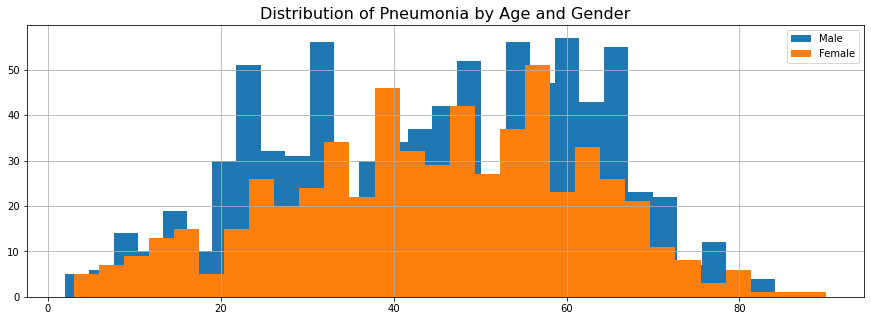

In [27]:
# visualize
df1 = all_xray_df[(all_xray_df['Pneumonia'] == 1) & (all_xray_df['Patient Gender'] == 'M') & (all_xray_df['Patient Age'] < 100)]['Patient Age']
df2 = all_xray_df[(all_xray_df['Pneumonia'] == 1) & (all_xray_df['Patient Gender'] == 'F') & (all_xray_df['Patient Age'] < 100)]['Patient Age']
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Male")
df2.hist(bins=30, label="Female")
ax.set_title("Distribution of Pneumonia by Age and Gender", fontsize=16);
plt.legend();

There is a good representation of Pneumonia in age ranging from 20 to 70 years and also between Male and Female with Male on a slightly higher side.

### Distribution by Gender

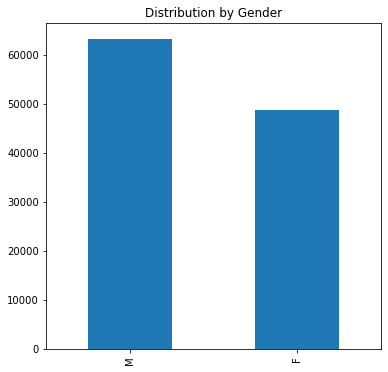

In [9]:
# histogram of patient's gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Distribution by Gender');

Male and Female have almost equal representation with Male having slightly higher number than Female.

**Pneumonia by Gender:**

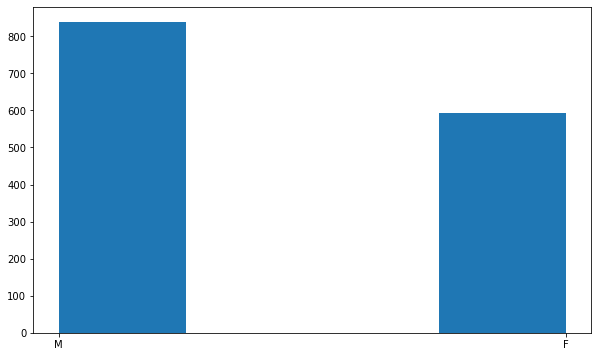

In [11]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'], bins=4);

### Distribution by Patient's View Position

- AP stands for anteriorposterior and is an X-ray with patient facing machine 
- PA stands for posterioranterior and occurs when a patient's back is toward the machine.

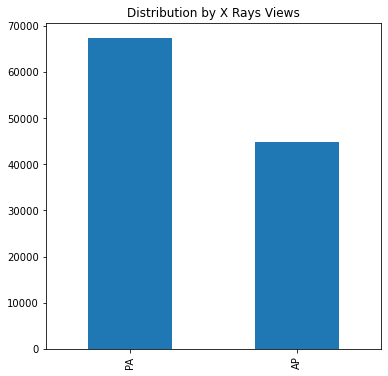

In [12]:
# histogram of patient's view position
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.title('Distribution by X Rays Views');

## Diseases

### Distribution of all diseases:

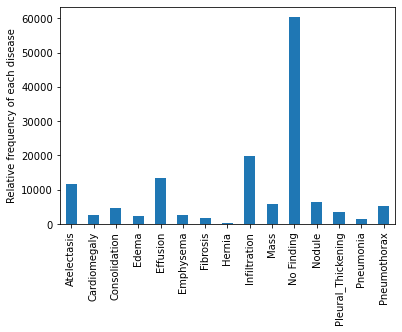

In [14]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Relative frequency of each disease');

'No Finding' has the highest occurrence which means half the dataset has no finding in the images.

### Pneumonia Cases

In [15]:
all_xray_df['Pneumonia'].value_counts()

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

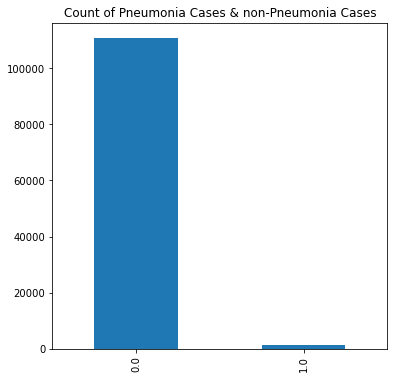

In [16]:
# histogram of patient's view position
plt.figure(figsize=(6,6))
all_xray_df['Pneumonia'].value_counts().plot(kind='bar')
plt.title('Count of Pneumonia Cases & non-Pneumonia Cases');

### Distribution of other diseases that are comorbid with pneumonia:

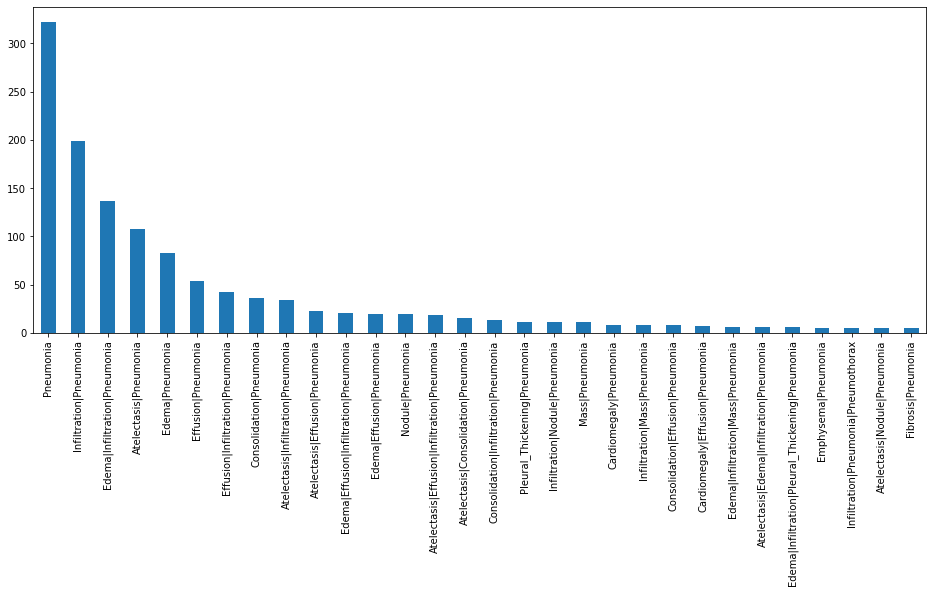

In [17]:
##Since there are many combinations of potential findings, let's look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar');

### Disease per patient:

In [18]:
# pivot by Patient ID and sum occurence of diseases
patient_df = all_xray_df.groupby('Patient ID').sum()
patient_df.reset_index(level=0, inplace=True)
patient_df.drop(columns=['Patient Age'], inplace=True)

In [19]:
patient_df.head(20)

,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pixel Level Assessment of Imaging data

Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and comparison of distributions across diseases.

Read image data:

In [40]:
# get directory of image files
imgs = glob.glob("*.dcm")

In [41]:
imgs

['test2.dcm', 'test5.dcm', 'test1.dcm', 'test4.dcm', 'test6.dcm', 'test3.dcm']

In [42]:
# read through each image file and create dicom filedataset for each image
dicom_lst = []
for img in imgs:
  t = pydicom.dcmread(img)
  dicom_lst.append(t)

In [43]:
# check which patient has diseases diagnosed
for img in dicom_lst:
  print("Disease finding for Patient ID: {} is {}".format(img.PatientID, img.StudyDescription))

Disease finding for Patient ID: 1 is Cardiomegaly
Disease finding for Patient ID: 2 is No Finding
Disease finding for Patient ID: 2 is No Finding
Disease finding for Patient ID: 2 is No Finding
Disease finding for Patient ID: 2 is No Finding
Disease finding for Patient ID: 61 is Effusion


The images provided are for three patients: 1, 2 & 61. Patient 2 has no finding.

In [44]:
# function to normalize pixel array for a dcm
def norm_intensity(dcm):
  mean_intensity = np.mean(dcm.pixel_array)
  std_intensity = np.std(dcm.pixel_array)
  new_img = dcm.pixel_array.copy()
  new_img = (new_img - mean_intensity)/std_intensity
  return new_img

**Patient ID 2 - Healthy**

Imaging data for healthy patients:

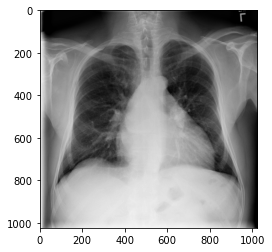

In [45]:
# X-ray image for Patient 2
plt.imshow(dicom_lst[0].pixel_array,cmap='gray');

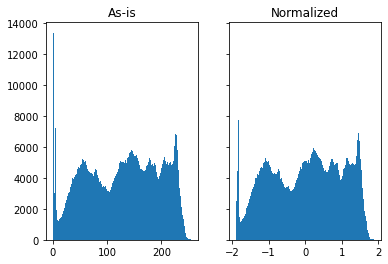

In [46]:
# Distribution of pixel data for Patient 2
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].hist(dicom_lst[0].pixel_array.ravel(), bins = 256)
axes[0].set_title('As-is')
axes[1].hist(norm_intensity(dicom_lst[0]).ravel(), bins = 256)
axes[1].set_title('Normalized');

**Patient ID 1 - Cardiomegaly**

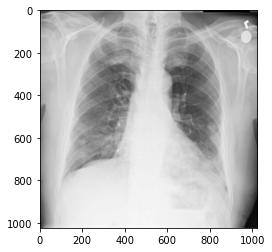

In [47]:
# X-ray image for Patient ID 1
plt.imshow(dicom_lst[1].pixel_array,cmap='gray');

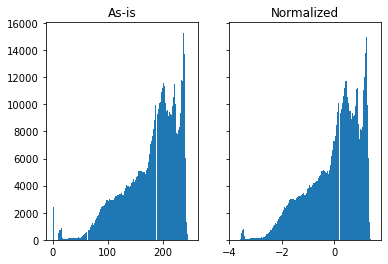

In [48]:
# Distribution of pixel data for Patient ID 61
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].hist(dicom_lst[2].pixel_array.ravel(), bins = 256)
axes[0].set_title('As-is')
axes[1].hist(norm_intensity(dicom_lst[2]).ravel(), bins = 256)
axes[1].set_title('Normalized');